In [1]:
import random
random.seed(12)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import cv2

import math

from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [2]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
#         X = X.split()
        X = np.array(X, dtype=np.uint8)
        X = X.reshape(48,48)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(image=X)['image']

#             X = torch.cat((X,X,X),0)

        return X, y

In [4]:
batch_size= 64

df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']


train_transforms = A.Compose([
#     A.CLAHE(),
    A.Resize(64,64),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, p=0.5, border_mode=0, value=0),
#     A.RandomCrop(height=40, width=40),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2()
])


test_transforms = A.Compose([
#     A.CLAHE(),
    A.Resize(64,64),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2()
])

train_set = FERDataset(df_train, train_transforms)
val_set = FERDataset(df_val, test_transforms)
test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Cosine Att

In [31]:
class CosineAtt(nn.Module):
    def __init__(self, in_channels):
        super(CosineAtt, self).__init__()
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
#         self.lmap = nn.Linear(in_channels, in_channels)
        self.lmap = nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x, mean=True, sigmoid=True):
        b, d, h, w = x.size()
#         x_avg = self.avgpool(x)
#         x_avg = x_avg.view(b, d)
        
        feature = self.lmap(x)
        feature = feature.view(b,d,h*w)
        cor_sim = self.cal_corsim(feature, mean, sigmoid) #shape b, d, d, hw
        
        if mean:
            out_feature = torch.bmm(cor_sim, feature)
            out_feature = out_feature.view(b,d,h,w)
            
#             sim_loss = cor_sim.sum(1).sum(1) / d
#             print(sim_loss)
#             sim_loss = 1 - (sim_loss.sum() / b)
            sim_loss = 1 - cor_sim.mean()
#             print(sim_loss)
        else:
            out_feature = cor_sim * feature.permute(0,2,1).unsqueeze(2)
            out_feature = out_feature.sum(2)
            out_feature = out_feature.permute(0,2,1).view(b,d,h,w)
            
            sim_loss = cor_sim.mean(1).sum(1).sum(1) / d
            sim_loss = 1 - (sim_loss.sum() / b)
        
        return out_feature, sim_loss
        
        
    def cal_corsim(self, x, mean=True, sigmoid=True):
        b, n_depth, _ = x.size()
        x_norm = x.norm(dim=2, keepdim=True)
        norms = 1. / torch.bmm(x_norm, x_norm.permute(0,2,1))

        ones = torch.ones((n_depth, n_depth)).to(x.device)
        diag = torch.ones((n_depth, n_depth)).to(x.device)
        diag.masked_fill_(torch.eye(n_depth, n_depth).to(x.device).byte(), 0)

        cor = x.permute(0,2,1).unsqueeze(-1) @ x.permute(0,2,1).unsqueeze(2)
        cor = (cor * norms[:,None, :, :]) + ones[None,None,:,:] # norm
        
        if mean: # reduce computation by meaning the hw-dimension
            cor = cor.mean(1)
            
        if sigmoid:
            cor = cor.sigmoid()
        # ensure the diag is vector 1.
        cor = (cor * diag) + torch.eye(n_depth, n_depth).to(x.device)

        return cor

In [30]:
CosineAtt(64)(torch.rand(12,64,24,24))

tensor(0.2647, grad_fn=<RsubBackward1>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:650.)


(tensor([[[[ 2.7390e+00,  2.1070e+00,  1.1579e+00,  ...,  2.0545e+00,
             2.7916e+00, -2.6623e-01],
           [ 1.6258e+00,  1.8207e+00,  4.5265e-01,  ...,  1.3804e+00,
             5.7104e-01,  1.0487e+00],
           [ 1.3531e+00,  1.9807e+00,  2.4301e+00,  ...,  1.0332e+00,
             1.5538e+00,  1.3185e+00],
           ...,
           [ 1.1805e+00,  2.1798e+00,  5.6542e-01,  ...,  1.7611e+00,
             1.0955e+00,  2.1482e+00],
           [ 1.0851e+00,  1.5307e+00,  1.5676e+00,  ...,  1.5538e+00,
             1.7394e+00, -1.3741e-01],
           [ 1.5805e+00,  1.4561e+00,  2.7194e-01,  ...,  2.4608e+00,
             1.8465e+00,  2.1291e+00]],
 
          [[ 2.7697e+00,  2.1302e+00,  1.2451e+00,  ...,  2.0405e+00,
             2.9549e+00, -2.8265e-01],
           [ 1.7473e+00,  1.7819e+00,  4.0586e-01,  ...,  1.4056e+00,
             5.6627e-01,  1.0804e+00],
           [ 1.3220e+00,  1.9290e+00,  2.4981e+00,  ...,  1.0071e+00,
             1.6094e+00,  1.4626e+00],


In [32]:
class SimpleNet(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(SimpleNet, self).__init__()
        
        self.conv1a = nn.Conv2d(in_channels, 64, 3, stride=1, padding=1)
        self.bn1a = nn.BatchNorm2d(64)
        self.conv1b = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2a = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.bn2a = nn.BatchNorm2d(128)
        self.conv2b = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3a = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.bn3a = nn.BatchNorm2d(256)
        self.conv3b = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.bn3b = nn.BatchNorm2d(256)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
        self.cosineatt = CosineAtt(256)
        
        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d(output_size=(1,1)),
                                        nn.Flatten(),
                                        nn.Linear(256, 256),
                                        nn.ReLU(),
                                        nn.Linear(256, n_classes))
        
    def forward(self, x):
        x = self.conv1a(x)
        x = self.bn1a(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x = self.pool(x)
        
        x = self.conv2a(x)
        x = self.bn2a(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x = self.pool(x)
        
        x = self.conv3a(x)
        x = self.bn3a(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x = self.pool(x)
        
        feature, sim_loss = self.cosineatt(x)
        
        out = self.classifier(feature)
        
        return out, sim_loss, feature

In [5]:
class PretrainedSimpleNet(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(PretrainedSimpleNet, self).__init__()
        
        self.init_conv = nn.Sequential(nn.Conv2d(1, 3, kernel_size=1, stride=1, padding=0),
                                       nn.BatchNorm2d(3))
        self.features = models.vgg16_bn().features[:20]
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
        self.cosineatt = CosineAtt(256)
        
        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d(output_size=(1,1)),
                                        nn.Flatten(),
                                        nn.Linear(256, 256),
                                        nn.ReLU(),
                                        nn.Linear(256, n_classes))
        
    def forward(self, x):
      
        x = self.init_conv(x)
        x = self.features(x)
        x = self.pool(x)
        
        feature = self.cosineatt(x)
        
        out = self.classifier(feature)
        
        return out, 0.0, feature

In [33]:
device = torch.device('cuda')
model = SimpleNet(1, 7).to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)


In [34]:
MAX_LOGSTD=10
model_path = 'multiatt/cosineatt_simplenet2_model.pt'
alpha = 0.1

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs)
        loss = criterion(outputs, labels)
        loss = loss + (alpha*sim_loss)

        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()
        
        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs)
        loss = criterion(outputs, labels)
        loss = loss + (alpha*sim_loss)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:28.)
Loss=1.7814204692840576 Batch_id=448 Accuracy=0.40540540540540543: 100%|██████████| 449/449 [00:37<00:00, 11.83it/s]

- Avg.loss: 1.8186 | Avg.acc: 0.2597



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9819 | Avg. val_acc: 0.2708
* Update optimal model
Epoch:  2


Loss=1.5154262781143188 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:38<00:00, 11.79it/s]

- Avg.loss: 1.6833 | Avg.acc: 0.3325



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6156 | Avg. val_acc: 0.3461
* Update optimal model
Epoch:  3


Loss=1.607708215713501 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:38<00:00, 11.77it/s]

- Avg.loss: 1.6014 | Avg.acc: 0.3692



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6774 | Avg. val_acc: 0.3536
* Update optimal model
Epoch:  4


Loss=1.6912102699279785 Batch_id=448 Accuracy=0.2702702702702703: 100%|██████████| 449/449 [00:38<00:00, 11.74it/s]

- Avg.loss: 1.5298 | Avg.acc: 0.4084



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.4144 | Avg. val_acc: 0.1992
Epoch:  5


Loss=1.6142523288726807 Batch_id=448 Accuracy=0.32432432432432434: 100%|██████████| 449/449 [00:38<00:00, 11.76it/s]

- Avg.loss: 1.4551 | Avg.acc: 0.4441



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4050 | Avg. val_acc: 0.4831
* Update optimal model
Epoch:  6


Loss=1.3313244581222534 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:38<00:00, 11.72it/s]

- Avg.loss: 1.3944 | Avg.acc: 0.4710



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3880 | Avg. val_acc: 0.4745
Epoch:  7


Loss=1.151037335395813 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:38<00:00, 11.74it/s]

- Avg.loss: 1.3413 | Avg.acc: 0.4952



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0451 | Avg. val_acc: 0.2937
Epoch:  8


Loss=1.3191957473754883 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:38<00:00, 11.73it/s]

- Avg.loss: 1.3010 | Avg.acc: 0.5135



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4124 | Avg. val_acc: 0.4890
* Update optimal model
Epoch:  9


Loss=1.0845263004302979 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:38<00:00, 11.73it/s]

- Avg.loss: 1.2614 | Avg.acc: 0.5319



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2469 | Avg. val_acc: 0.5319
* Update optimal model
Epoch:  10


Loss=1.1246103048324585 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:38<00:00, 11.72it/s]

- Avg.loss: 1.2197 | Avg.acc: 0.5447



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2169 | Avg. val_acc: 0.5514
* Update optimal model
Epoch:  11


Loss=1.0509166717529297 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:38<00:00, 11.73it/s]

- Avg.loss: 1.1804 | Avg.acc: 0.5618



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4416 | Avg. val_acc: 0.5043
Epoch:  12


Loss=1.0152819156646729 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:38<00:00, 11.73it/s]

- Avg.loss: 1.1530 | Avg.acc: 0.5762



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1762 | Avg. val_acc: 0.5626
* Update optimal model
Epoch:  13


Loss=1.2908031940460205 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:38<00:00, 11.72it/s]

- Avg.loss: 1.1307 | Avg.acc: 0.5839



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1673 | Avg. val_acc: 0.5743
* Update optimal model
Epoch:  14


Loss=1.3197214603424072 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:38<00:00, 11.71it/s]

- Avg.loss: 1.0937 | Avg.acc: 0.5998



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2142 | Avg. val_acc: 0.5592
Epoch:  15


Loss=1.064610481262207 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:38<00:00, 11.71it/s]

- Avg.loss: 1.0702 | Avg.acc: 0.6070



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4307 | Avg. val_acc: 0.5269
Epoch:  16


Loss=1.1054786443710327 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:38<00:00, 11.70it/s]

- Avg.loss: 1.0386 | Avg.acc: 0.6198



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2931 | Avg. val_acc: 0.5322
Epoch:  17


Loss=0.9726269245147705 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:38<00:00, 11.69it/s]

- Avg.loss: 1.0148 | Avg.acc: 0.6321



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3361 | Avg. val_acc: 0.5447
Epoch:  18


Loss=0.865822970867157 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:38<00:00, 11.72it/s]

- Avg.loss: 1.0094 | Avg.acc: 0.6325



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4801 | Avg. val_acc: 0.4762
Epoch:  19


Loss=1.00160551071167 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:38<00:00, 11.71it/s]

- Avg.loss: 0.9710 | Avg.acc: 0.6483



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3959 | Avg. val_acc: 0.5169
Epoch    19: reducing learning rate of group 0 to 7.5000e-05.
Epoch:  20


Loss=0.6171404719352722 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:38<00:00, 11.70it/s]

- Avg.loss: 0.9133 | Avg.acc: 0.6727



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3507 | Avg. val_acc: 0.5578
Epoch:  21


Loss=0.9617598056793213 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:38<00:00, 11.70it/s]

- Avg.loss: 0.8532 | Avg.acc: 0.6961



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9772 | Avg. val_acc: 0.4177
Epoch:  24


Loss=0.7348388433456421 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:38<00:00, 11.69it/s]

- Avg.loss: 0.8430 | Avg.acc: 0.7015



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2675 | Avg. val_acc: 0.5520
Epoch:  25


Loss=0.9326058030128479 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:38<00:00, 11.68it/s]

- Avg.loss: 0.8174 | Avg.acc: 0.7088



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4316 | Avg. val_acc: 0.5559
Epoch:  26


Loss=0.6892001032829285 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:38<00:00, 11.68it/s]

- Avg.loss: 0.7954 | Avg.acc: 0.7198



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2839 | Avg. val_acc: 0.5776
Epoch:  27


Loss=0.7909859418869019 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:38<00:00, 11.72it/s]

- Avg.loss: 0.7841 | Avg.acc: 0.7238



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5675 | Avg. val_acc: 0.4915
Epoch    27: reducing learning rate of group 0 to 5.6250e-05.
Epoch:  28


Loss=0.8038917779922485 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:38<00:00, 11.70it/s]

- Avg.loss: 0.7350 | Avg.acc: 0.7433



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2216 | Avg. val_acc: 0.6149
* Update optimal model
Epoch:  29


Loss=0.6424102783203125 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:38<00:00, 11.66it/s]

- Avg.loss: 0.7102 | Avg.acc: 0.7512



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2220 | Avg. val_acc: 0.6233
* Update optimal model
Epoch:  30


Loss=1.0583734512329102 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:38<00:00, 11.69it/s]

- Avg.loss: 0.6951 | Avg.acc: 0.7590



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1463 | Avg. val_acc: 0.6289
* Update optimal model
Epoch:  31


Loss=0.46292221546173096 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:38<00:00, 11.69it/s]

- Avg.loss: 0.6813 | Avg.acc: 0.7651



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3595 | Avg. val_acc: 0.5896
Epoch:  32


Loss=0.78302401304245 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:38<00:00, 11.70it/s]

- Avg.loss: 0.6578 | Avg.acc: 0.7712



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5378 | Avg. val_acc: 0.5492
Epoch:  33


Loss=0.48364582657814026 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:38<00:00, 11.69it/s]

- Avg.loss: 0.6505 | Avg.acc: 0.7755



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2927 | Avg. val_acc: 0.6227
Epoch:  34


Loss=0.7039791345596313 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:38<00:00, 11.68it/s]

- Avg.loss: 0.6414 | Avg.acc: 0.7801



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2511 | Avg. val_acc: 0.6183
Epoch:  35


Loss=0.9053224325180054 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:38<00:00, 11.68it/s]

- Avg.loss: 0.6203 | Avg.acc: 0.7861



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6274 | Avg. val_acc: 0.5631
Epoch:  36


Loss=0.702356219291687 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:38<00:00, 11.70it/s]

- Avg.loss: 0.6003 | Avg.acc: 0.7958



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2441 | Avg. val_acc: 0.6322
* Update optimal model
Epoch:  37


Loss=0.6712605953216553 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:38<00:00, 11.71it/s]

- Avg.loss: 0.6002 | Avg.acc: 0.7926



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4185 | Avg. val_acc: 0.5843
Epoch:  38


Loss=0.4837721288204193 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:38<00:00, 11.70it/s]

- Avg.loss: 0.5777 | Avg.acc: 0.8039



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3997 | Avg. val_acc: 0.6041
Epoch:  39


Loss=0.7852675914764404 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:38<00:00, 11.69it/s]

- Avg.loss: 0.5827 | Avg.acc: 0.8020



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4146 | Avg. val_acc: 0.6144
Epoch:  40


Loss=0.5386984944343567 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:38<00:00, 11.69it/s]

- Avg.loss: 0.5620 | Avg.acc: 0.8124



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5768 | Avg. val_acc: 0.5428
Epoch:  41


Loss=0.4467761516571045 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:38<00:00, 11.67it/s]

- Avg.loss: 0.5574 | Avg.acc: 0.8115



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4752 | Avg. val_acc: 0.5740
Epoch:  42


Loss=0.6951011419296265 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:38<00:00, 11.69it/s]

- Avg.loss: 0.5473 | Avg.acc: 0.8143



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4872 | Avg. val_acc: 0.5871
Epoch    42: reducing learning rate of group 0 to 4.2188e-05.
Epoch:  43


Loss=0.44391337037086487 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:38<00:00, 11.68it/s]

- Avg.loss: 0.5043 | Avg.acc: 0.8349



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6529 | Avg. val_acc: 0.5740
Epoch:  44


Loss=0.3159162998199463 Batch_id=31 Accuracy=0.9375:   7%|▋         | 32/449 [00:03<00:42,  9.87it/s]   


KeyboardInterrupt: 

In [16]:
sim_loss

tensor(-186.4208, device='cuda:0', grad_fn=<RsubBackward1>)

In [9]:
best_acc

0.6586792978545556

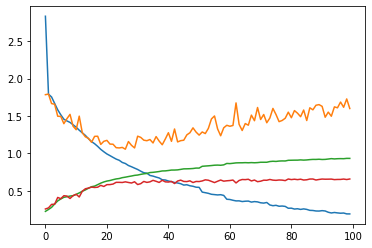

In [10]:
plt.plot(hist)

In [11]:
model = torch.load('multiatt/cosineatt_simplenet_model.pt')
# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs, kl_loss, features = model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:28.)


- Avg. val_loss: 1.5104 | Avg. val_acc: 0.6679


In [18]:
# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
_features = []
_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
#     labels = labels.to(device)
    _labels.append(labels.cpu())
    
    with torch.no_grad():
        outputs, kl_loss, features = model(inputs)
        features = nn.AdaptiveAvgPool2d(output_size=(1,1))(features)
        features = nn.Flatten()(features)
    _features.append(features.detach().cpu())

#     loss = criterion(outputs, labels)
#     centloss = center_loss(features, labels)
#     loss = loss + ((1/len(inputs))*kl_loss) + (alpha*centloss)
#     acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

#     running_valloss += (loss.item() * inputs.size(0))
#     running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:28.)


- Avg. val_loss: 0.0000 | Avg. val_acc: 0.0000


In [19]:
features = torch.cat(_features).detach().cpu().numpy()
labels = torch.cat(_labels).cpu().numpy()
label_dict={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
str_labels = [label_dict[int(k)] for k in labels]

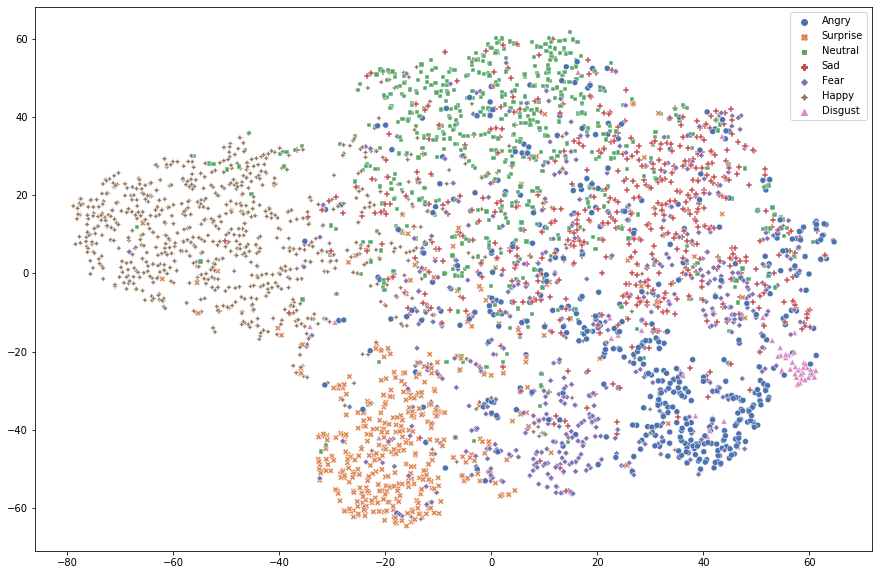

In [21]:
from sklearn.manifold import TSNE

tsne_features = TSNE(n_components=2).fit_transform(features)

import seaborn as sns

fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(ax=ax, x=tsne_features[:,0], y=tsne_features[:,1], hue=str_labels, style=str_labels, palette="deep")


In [7]:
MAX_LOGSTD=10
model_path = 'multiatt/cosineatt_pretrainedsimplenet_model.pt'

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, kl_loss, features = model(inputs)
        loss = criterion(outputs, labels)

        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()
        
        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, kl_loss, features = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/898 [00:00<?, ?it/s]

Epoch:  1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:28.)
Loss=2.331925392150879 Batch_id=897 Accuracy=0.0: 100%|██████████| 898/898 [01:43<00:00,  8.70it/s]     

- Avg.loss: 3.2622 | Avg.acc: 0.2409



  0%|          | 0/898 [00:00<?, ?it/s]

- Avg. val_loss: 2.5262 | Avg. val_acc: 0.2984
* Update optimal model
Epoch:  2


Loss=1.7534363269805908 Batch_id=897 Accuracy=0.4: 100%|██████████| 898/898 [01:43<00:00,  8.67it/s]    

- Avg.loss: 2.0607 | Avg.acc: 0.2921



  0%|          | 0/898 [00:00<?, ?it/s]

- Avg. val_loss: 2.0760 | Avg. val_acc: 0.2870
Epoch:  3


Loss=1.614792823791504 Batch_id=897 Accuracy=0.4: 100%|██████████| 898/898 [01:43<00:00,  8.66it/s]     

- Avg.loss: 1.8529 | Avg.acc: 0.3297



  0%|          | 0/898 [00:00<?, ?it/s]

- Avg. val_loss: 1.7671 | Avg. val_acc: 0.3681
* Update optimal model
Epoch:  4


Loss=0.9843722581863403 Batch_id=897 Accuracy=0.6: 100%|██████████| 898/898 [01:43<00:00,  8.65it/s]    

- Avg.loss: 1.7594 | Avg.acc: 0.3648



  0%|          | 0/898 [00:00<?, ?it/s]

- Avg. val_loss: 1.6906 | Avg. val_acc: 0.3720
* Update optimal model
Epoch:  5


Loss=1.748752236366272 Batch_id=897 Accuracy=0.6: 100%|██████████| 898/898 [01:43<00:00,  8.65it/s]     

- Avg.loss: 1.6552 | Avg.acc: 0.3933



  0%|          | 0/898 [00:00<?, ?it/s]

- Avg. val_loss: 1.5468 | Avg. val_acc: 0.4280
* Update optimal model
Epoch:  6


Loss=0.7139241695404053 Batch_id=897 Accuracy=0.6: 100%|██████████| 898/898 [01:43<00:00,  8.64it/s]    

- Avg.loss: 1.5892 | Avg.acc: 0.4160



  0%|          | 0/898 [00:00<?, ?it/s]

- Avg. val_loss: 1.4567 | Avg. val_acc: 0.4531
* Update optimal model
Epoch:  7


Loss=1.4627052545547485 Batch_id=897 Accuracy=0.4: 100%|██████████| 898/898 [01:43<00:00,  8.64it/s]    

- Avg.loss: 1.5166 | Avg.acc: 0.4393



  0%|          | 0/898 [00:00<?, ?it/s]

- Avg. val_loss: 1.3640 | Avg. val_acc: 0.4798
* Update optimal model
Epoch:  8


Loss=2.519881010055542 Batch_id=897 Accuracy=0.2: 100%|██████████| 898/898 [01:43<00:00,  8.64it/s]     

- Avg.loss: 1.4463 | Avg.acc: 0.4603



  0%|          | 0/898 [00:00<?, ?it/s]

- Avg. val_loss: 1.3447 | Avg. val_acc: 0.5015
* Update optimal model
Epoch:  9


Loss=0.9509947896003723 Batch_id=897 Accuracy=0.6: 100%|██████████| 898/898 [01:43<00:00,  8.64it/s]    

- Avg.loss: 1.3987 | Avg.acc: 0.4783



  0%|          | 0/898 [00:00<?, ?it/s]

- Avg. val_loss: 1.2812 | Avg. val_acc: 0.5208
* Update optimal model
Epoch:  10


Loss=1.2996724843978882 Batch_id=897 Accuracy=0.4: 100%|██████████| 898/898 [01:43<00:00,  8.64it/s]    

- Avg.loss: 1.3514 | Avg.acc: 0.4940



  0%|          | 0/898 [00:00<?, ?it/s]

- Avg. val_loss: 1.2421 | Avg. val_acc: 0.5241
* Update optimal model
Epoch:  11


Loss=1.3416844606399536 Batch_id=734 Accuracy=0.4375:  82%|████████▏ | 735/898 [01:25<00:18,  8.62it/s] 


KeyboardInterrupt: 